In [ ]:
hs = [[1, 4, 5], [2, 4, 5]]

In [ ]:
[list(pair) for pair in zip(*hs)]

[[1, 2], [4, 4], [5, 5]]

# `run.test`

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#default_exp run.test

In [ ]:
# %load ../../../HPA-competition-solutions/bestfitting/src/run/test.py

In [ ]:
#export

import os, sys
import argparse
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import pycocotools.mask as mutils
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.nn import DataParallel
import torch.nn.functional as F
from torch.autograd import Variable

from kgl_humanprotein.config.config import *
from kgl_humanprotein.data_process import *
from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.networks.imageclsnet import init_network
from kgl_humanprotein.datasets.protein_dataset import ProteinDataset, ProteinTestDataset
from kgl_humanprotein.utils.augment_util import *
from kgl_humanprotein.utils.log_util import Logger

In [ ]:
# import holoviews as hv
# hv.extension('bokeh')

# Option 1: No cell crops I/O

## Setup

In [ ]:
dir_inp = Path('../../kgl_humanprotein_data') # Path('/kaggle/input')
dir_out = Path('./') # Path('/kaggle/working')

dir_hpa = dir_inp/'hpa-single-cell-image-classification'
dir_test = dir_hpa / 'test'

## Inference parameters

In [ ]:
out_dir = ('external_crop256_focal_slov_hardlog_class'
           '_densenet121_dropout_i384_aug2_5folds')
seeds = '0'
fold = 0
predict_epoch = None
augment = 'default'

sz_img = 80
sz_crop = 64
bs = 2 # 8

threshold = 0.5

num_workers = 0 # 3
pin_memory = False # True

## Dummy submission

In [ ]:
#export

def dummy_predict_image(img):
    pred = 0
    conf = .5
    
    height, width = img.shape[:2]
    bmask = np.zeros((height, width), dtype=np.uint8)
    bmask[:height//3, :width//3] = 1
    
    rle = mutils.encode(np.asfortranarray(bmask))
    coco_rle = {'size': [height, width], 'counts': rle}
    return pred, conf, rle


def write_dummy_submission(dir_test, imgids, dst=Path('./')):
    
    with open(dst/'submission.csv', mode='w') as f:
        print(
            'ID,ImageWidth,ImageHeight,PredictionString', file=f)
        
        for imgid in imgids:
            img = load_RGBY_image(dir_test, imgid)

            pred, conf, rle = dummy_predict_image(img)
            bmask = mutils.decode(rle)
            rle = encode_binary_mask(bmask.astype(bool))

            predstring = f'{pred} {conf} {rle}'

            height, width = img.shape[:2]
            submn_img = f'{imgid}, {width}, {height}, {predstring}'
            print(submn_img, file=f)

In [ ]:
# (hv.RGB(img[...,:3]) * hv.Image(bmask)).opts(
#     hv.opts.RGB(yaxis=None, xaxis=None),
#     hv.opts.Image(yaxis=None, xaxis=None, alpha=.5)
# )

In [ ]:
write_dummy_submission(dir_test, imgids, )

In [ ]:
pd.read_csv('submission.csv')

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 0.5 eNoziEo1SIsyNBgFo2AUjIJRQB0QEBCTagQADzI...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 0.5 eNoziEo1SIsyNBgFo2AUjIJRQB0QEBCTagQADzI...


## Model

In [ ]:
#export

def load_model(network_path, arch='class_densenet121_dropout', 
               num_classes=19, in_channels=4):
    model_params = {}
    model_params['architecture'] = arch
    model_params['num_classes'] = num_classes
    model_params['in_channels'] = in_channels
    model = init_network(model_params)

    checkpoint = torch.load(network_path)
    model.load_state_dict(checkpoint['state_dict'])
    model = nn.DataParallel(model)
    model.to(DEVICE)
    model.eval()
    return model

In [ ]:
arch = 'class_densenet121_dropout'

In [ ]:
predict_epoch = 'final' if predict_epoch is None else '%03d' % predict_epoch
network_path = RESULT_DIR/'models'/out_dir/f'fold{fold:d}'/f'{predict_epoch}.pth'

In [ ]:
network_path

PosixPath('../../kgl_humanprotein_data/result/models/external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/fold0/final.pth')

In [ ]:
model = load_model(network_path, arch=arch)

>> Using pre-trained model.


## HPA Cell Segmentator

In [ ]:
dir_segmentator_models = Path('../../hpa-cell-segmentation-models/')

segmentator = load_segmentator(dir_segmentator_models, padding=True)

No GPU found, using CPU.


please compile abn


## Data

In [ ]:
imgids = imgids_from_directory(dir_test)

# If on Kaggle
# imgids = list(pd.read_csv(dir_hpa/'sample_submission.csv')['ID'].values)

# if len(imgids) == 559:
#     debug = True
#     imgids = list(np.random.choice(imgids, 10))

## Inference

In [ ]:
#export

def segment_batch_image(batch_img):
    batch_img_red    = [img[...,0] for img in batch_img]
    batch_img_yellow = [img[...,3] for img in batch_img]
    batch_img_blue   = [img[...,2] for img in batch_img]
    masks = segmentator(batch_img_red, batch_img_yellow, batch_img_blue)
    batch_mask = [mask_cell for mask_nucl, mask_cell in masks]
    return batch_mask


def image_predict(dl, model, threshold=0.5):
    '''
    Predict on an image.
    '''
    with torch.no_grad():
        images, indices = next(iter(dl))
        assert len(images) == len(indices) == len(dl.dataset)
        images = Variable(images.to(DEVICE), volatile=True)
        outputs = model(images)
        logits = outputs
        probs = F.sigmoid(logits).data
    probs[range(len(probs)), probs.argmax(axis=1)] = 1
    assert len(probs) == len(dl.dataset)
    preds = [torch.where(prob > threshold)[0] for prob in probs]
    confs = [prob[pred] for pred, prob in zip(preds, probs)]
    return preds, confs    


def image_submitstring(imgid=None, img=None, bmasks=None, preds=None, confs=None):
    '''
    Form submission string for an image.
    '''
    enrles = [encode_binary_mask(bmask.astype(bool))for bmask in bmasks]
    # enrles = [f'cell_{i}' for i in range(len(bmasks))]
    predstring = ' '.join(f'{p} {c:.4f} {enrle}' 
                          for pred, conf, enrle in zip(preds, confs, enrles) 
                          for p, c in zip(list(pred), conf))
    submitstring = f'{imgid}, {img.shape[1]}, {img.shape[0]}, {predstring}'
    return submitstring

In [ ]:
# with open('submission.csv', mode='w') as file_submit:
#     print('ID, ImageWidth, ImageHeight, PredictionString', file=file_submit)

In [ ]:
i_batch = 1

In [ ]:
batch_imgid = imgids[i_batch:i_batch+bs]
batch_img = [load_RGBY_image(dir_test, imgid) for imgid in batch_imgid]

In [ ]:
%%time
batch_mask = segment_batch_image(batch_img)

CPU times: user 37.7 s, sys: 4.39 s, total: 42.1 s
Wall time: 44.8 s


In [ ]:
batch_rles   = [mask2rles(mask) for mask in batch_mask]
batch_bmasks = [[mutils.decode(rle) for rle in rles] for rles in batch_rles]
batch_bboxes = [rles2bboxes(rles) for rles in batch_rles]

In [ ]:
batch_cells = [[crop_image(img, bbox, bmask=bmask) for bbox, bmask in zip(bboxes, bmasks)] 
               for img, bboxes, bmasks in zip(batch_img, batch_bboxes, batch_bmasks)]
batch_cells = [[resize_image(pad_to_square(cell), sz_img) for cell in cells] 
               for cells in batch_cells]

In [ ]:
batch_ds = [ProteinTestDataset(cells, img_size=sz_img, crop_size=sz_crop) for cells in batch_cells]
batch_dl = [DataLoader(ds, sampler=SequentialSampler(ds), batch_size=len(ds),
                       drop_last=False, num_workers=num_workers, pin_memory=pin_memory) 
            for ds in batch_ds]

In [ ]:
batch_preds, batch_confs = [], []
for dl in batch_dl:
    preds, confs = image_predict(dl, model, threshold=threshold)
    batch_preds.append(preds)
    batch_confs.append(confs)

In [ ]:
batch_submitstring = [image_submitstring(imgid, img, bmasks, preds, confs) 
                      for imgid, img, bmasks, preds, confs 
                      in zip(batch_imgid, batch_img, batch_bmasks, batch_preds, batch_confs)]

In [ ]:
# print('\n'.join(batch_submitstring))

## Plots

In [ ]:
#export

def plt_image(ax, img, bmask=None, centres=None, texts=None):
    ax.imshow(img[...,:3])
    if bmask is not None:
        ax.imshow(bmask, cmap='cividis', alpha=.5)
    
    if (centres is not None) and (texts is not None):
        for centre, text in zip(centres, texts):
            x, y = centre
            ax.text(x, y, text, color='cyan')
    
    return ax

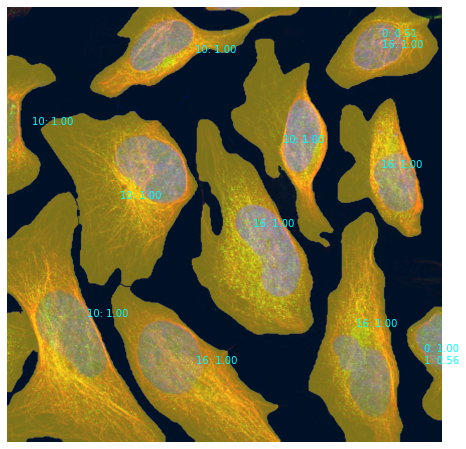

In [ ]:
idx = 0

img = batch_img[idx]
bmasks = batch_bmasks[idx]
preds = batch_preds[idx]
confs = batch_confs[idx]
bboxes = batch_bboxes[idx]

texts = ['\n'.join(f'{p}: {c:.2f}' for p, c in zip(pred, conf)) 
         for pred, conf in zip(preds, confs)]
centres = [(0.5*(x0 + x1), 0.5*(y0 + y1)) for x0, y0, x1, y1 in bboxes]

fig, ax = plt.subplots(figsize=(8, 8))
bmask_total = np.stack(bmasks, axis=0).sum(axis=0)
ax = plt_image(ax, img, bmask=bmask_total, centres=centres, texts=texts)
ax.axis('off');

# Option 2: Cell crops I/O

## Generate square crops of certain size

In [ ]:
img_size = 384

In [ ]:
dir_crops = DATA_DIR/'test'/f'images_{img_size}'
dir_crops.mkdir(exist_ok=True)

df_cells = generate_crops(
    df_cells, dir_test, dir_crops, out_sz=img_size)

df_cells.to_feather(dir_data_raw/'test.feather')

In [ ]:
create_split_file(data_set="test", name="test", num=None)

create split file: test_27


In [ ]:
# img = load_RGBY_image(dir_crops, df_cells['Id'].iloc[21])

# hv.RGB(img[...,:3])

run on collie.local
run on collie.local
run on collie.local


## Predict on cell crops

In this case, the test images are the image crops, each containing a cell.

In [ ]:
#export

datasets_names = ['test', 'val']
split_names = ['random_ext_folds5', 
               'random_ext_noleak_clean_folds5']
augment_list = ['default', 'flipud', 'fliplr','transpose', 
                'flipud_lr', 'flipud_transpose', 'fliplr_transpose',
                'flipud_lr_transpose']

In [ ]:
#export

def test(out_dir, 
         gpu_id='0', arch='class_densenet121_dropout', 
         num_classes=19, in_channels=4, img_size=768, crop_size=512, 
         batch_size=32, workers=3, pin_memory=True,
         seed=100, seeds=None, fold=0, augment='default', 
         dataset='test', sz_testset=None, split_name='random_ext_folds5',
         predict_epoch=None):  
    '''
    PyTorch Protein Classification
    
    Args:
        out_dir (str): Name of directory where model is saved.  This will 
            also be used to name a newly created directory for saving the
            predicted results.
        gpu_id (str): GPU id used for predicting. Default: ``'0'``
        arch (str): Model architecture. Default: ``'class_densenet121_dropout)'``
        num_classes (int): Number of classes. Default: 19
        in_channels (int): In channels. Default: 4
        img_size (int):  Image size. Default: 768
        crop_size (int): Crop size. Default: 512
        batch_size (int): Train mini-batch size. Default: 32
        workers (int): Number of data loading workers. Default: 3
        pin_memory (bool): DataLoader's ``pin_memory`` argument.
        fold (int): Index of fold. Default: 0
        augment (str):  Comma-separated string of one or more of 
            the following: ``'default'``, ``'flipud'``, ``'fliplr'``,
            ``'transpose'``, ``'flipud_lr'``, ``'flipud_transpose'``, 
            ``'fliplr_transpose'``, ``'flipud_lr_transpose'``.
            Default: ``'default'``
        seed (int):  Random seed. Default: 100
        seeds (str): Predict seed. Default: None
        dataset (str, optional): ``'test'``, or ``'val'``. Default: ``'test'``
        sz_testset (int): Number of cell crops in the test set.  Default: ``None``
        split_name (str, optional): ``'random_ext_folds5'``, or
            ``'random_ext_noleak_clean_folds5'``. Default: 'random_ext_folds5'
        predict_epoch (int): Number epoch to predict. Default: None
    '''
    if dataset not in datasets_names:
        print(f'`dataset` needs to be one of {datasets_names}.')
        raise

    if split_name not in split_names:
        print(f'`split_name` must be one of {split_names}.')
        raise

    log_out_dir = opj(RESULT_DIR, 'logs', out_dir, 'fold%d' % fold)
    if not ope(log_out_dir):
        os.makedirs(log_out_dir)
    log = Logger()
    log.open(opj(log_out_dir, 'log.submit.txt'), mode='a')

    predict_epoch = 'final' if predict_epoch is None else '%03d' % predict_epoch
    network_path = opj(RESULT_DIR, 'models', out_dir, 'fold%d' % fold, '%s.pth' % predict_epoch)

    submit_out_dir = opj(RESULT_DIR, 'submissions', out_dir, 'fold%d' % fold, 'epoch_%s' % predict_epoch)
    log.write(">> Creating directory if it does not exist:\n>> '{}'\n".format(submit_out_dir))
    if not ope(submit_out_dir):
        os.makedirs(submit_out_dir)

    # setting up the visible GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

    augment = augment.split(',')
    for augment_ in augment:
        if augment_ not in augment_list:
            raise ValueError('Unsupported or unknown test augmentation: {}!'.format(augment))

    model_params = {}
    model_params['architecture'] = arch
    model_params['num_classes'] = num_classes
    model_params['in_channels'] = in_channels
    model = init_network(model_params)

    log.write(">> Loading network:\n>>>> '{}'\n".format(network_path))
    checkpoint = torch.load(network_path)
#     _, in_features = checkpoint['state_dict']['logit.weight'].shape
#     logit_weight = torch.randn(num_classes, in_features)
#     logit_bias = torch.randn(num_classes)
#     checkpoint['state_dict']['logit.weight'] = logit_weight
#     checkpoint['state_dict']['logit.bias'] = logit_bias
    model.load_state_dict(checkpoint['state_dict'])
    log.write(">>>> loaded network:\n>>>> epoch {}\n".format(checkpoint['epoch']))

    # moving network to gpu and eval mode
    model = DataParallel(model)
    model.to(DEVICE)
    model.eval()

    # Data loading code
    if dataset == 'test':
        test_split_file = DATA_DIR/'split'/f'test_{sz_testset}.feather'
    elif dataset == 'val':
        test_split_file = opj(DATA_DIR, 'split', split_name, 'random_valid_cv%d.csv' % fold)
    else:
        raise ValueError('Unsupported or unknown dataset: {}!'.format(dataset))
        
    test_dataset = ProteinDataset(
        test_split_file,
        img_size=img_size,
        is_trainset=(dataset != 'test'),
        return_label=False,
        in_channels=in_channels,
        transform=None,
        crop_size=crop_size,
        random_crop=False)
    
    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size,
        drop_last=False,
        num_workers=workers,
        pin_memory=pin_memory)

    seeds = [seed] if seeds is None else [int(i) for i in seeds.split(',')]
    for seed in seeds:
        test_dataset.random_crop = (seed != 0)
        for augment_ in augment:
            test_loader.dataset.transform = eval('augment_%s' % augment_)
            if crop_size > 0:
                sub_submit_out_dir = opj(submit_out_dir, '%s_seed%d' % (augment_, seed))
            else:
                sub_submit_out_dir = opj(submit_out_dir, augment_)
            if not ope(sub_submit_out_dir):
                os.makedirs(sub_submit_out_dir)
            with torch.no_grad():
                predict(test_loader, model, sub_submit_out_dir, dataset)
                
    return submit_out_dir



def predict(test_loader, model, submit_out_dir, dataset):
    all_probs = []
    img_ids = np.array(test_loader.dataset.img_ids)
    for it, iter_data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
        images, indices = iter_data
        images = Variable(images.to(DEVICE), volatile=True)
        outputs = model(images)
        logits = outputs

        probs = F.sigmoid(logits).data
        all_probs += probs.cpu().numpy().tolist()
    img_ids = img_ids[:len(all_probs)]
    all_probs = np.array(all_probs).reshape(len(img_ids), -1)

    np.save(opj(submit_out_dir, 'prob_%s.npy' % dataset), all_probs)

    result_df = prob_to_result(all_probs, img_ids)
    result_df.to_csv(opj(submit_out_dir, 'results_%s.csv.gz' % dataset), index=False, compression='gzip')

def prob_to_result(probs, img_ids, th=0.5):
    probs = probs.copy()
    probs[np.arange(len(probs)), np.argmax(probs, axis=1)] = 1

    pred_list = []
    for line in probs:
        s = ' '.join(list([str(i) for i in np.nonzero(line > th)[0]]))
        pred_list.append(s)
    result_df = pd.DataFrame({ID: img_ids, PREDICTED: pred_list})
    return result_df

run on collie.local
run on collie.local
run on collie.local


In [ ]:
out_dir = ('external_crop512_focal_slov_hardlog_class'
           '_densenet121_dropout_i768_aug2_5folds')
gpu_id = '0'
arch = 'class_densenet121_dropout'
img_size = 384 #768
crop_size = 256 #512
seeds = '0' # '0,1,2,3',
batch_size = 16
sz_testset = len(df_cells)
fold = 0
augment = 'default' #'default,flipud,fliplr,transpose,flipud_lr,flipud_transpose,fliplr_transpose,flipud_lr_transpose')

In [ ]:
submit_out_dir = test(
    out_dir, gpu_id=gpu_id, arch=arch, img_size=img_size, sz_testset=sz_testset,
    crop_size=crop_size, seeds=seeds, batch_size=batch_size, 
    fold=fold, augment=augment)

>> Creating directory if it does not exist:
>> '../../kgl_humanprotein_data/result/submissions/external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds/fold0/epoch_final'
>> Using pre-trained model.
>> Loading network:
>>>> '../../kgl_humanprotein_data/result/models/external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds/fold0/final.pth'
>>>> loaded network:
>>>> epoch 2
../../kgl_humanprotein_data/protein/test/images_384
../../kgl_humanprotein_data/protein/train/external_v18_384


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


## Write submission file

In [ ]:
dir_results = Path(submit_out_dir)

In [ ]:
#export

def organise_results(df_cells, dir_results):
    if isinstance(dir_results, str):
        dir_results = Path(dir_results)
        
    preds = pd.read_csv(
        dir_results/'default_seed0'/'results_test.csv.gz')
    probs = np.load(dir_results/'default_seed0'/'prob_test.npy')

    preds = pd.merge(
        df_cells, preds, left_on='Id', right_on='Id', how='inner')

    preds['Image_Id'] = preds.apply(
        lambda o: o['Id'].split('_')[0], axis=1)
    
    return preds, probs

In [ ]:
#export

def write_submission_csv(preds, probs, dir_out=Path('/kaggle/working')):
    
    with open(dir_out / 'submission.csv', mode='w') as f_submission:
        print('ID,ImageWidth,ImageHeight,PredictionString', 
              file=f_submission)

        for imgid, df in preds.groupby('Image_Id'):

            pred_string = []
            for i, r in df.iterrows():

                bmask = mutils.decode(r['rle'])
                rle = encode_binary_mask(bmask.astype(bool))

                labels = r['Predicted'].split()
                labels = np.array([int(label) for label in labels])

                confidences = probs[i, labels]

                # To debug submission,
                # include just the first predicted label
                labels, confidences = labels[:1], confidences[:1]
                
                for label, confidence in zip(labels, confidences):
                    pred_string.append(f'{label} {confidence} {rle}')

            pred_string = ' '.join(pred_string)

            img_h, img_w = df.iloc[0]['rle']['size']
            img_string = f'{imgid}, {img_w}, {img_h}, {pred_string}'

            print(img_string, file=f_submission)


In [ ]:
preds, probs = organise_results(df_cells, dir_results)

In [ ]:
dir_out = Path('./')

In [ ]:
write_submission_csv(preds, probs, dir_out=dir_out)

In [ ]:
len(pd.read_csv('submission.csv').loc[1,'PredictionString'])

10863

In [ ]:
pd.read_csv('submission.csv')






run on collie.local
run on collie.local
run on collie.local


,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 0.5275797843933105 eNqlVNtygjAQ/aUspHam0+lD...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,3 0.5781107544898987 eNoLCEhJMAgwDMg3NPQ39Df2...
